In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statistics as stat
from scipy import stats
import pytz
import geopandas
import geopy
from geopy.geocoders import Nominatim
from sklearn.linear_model import LinearRegression
import folium
from folium.plugins import MarkerCluster
import statsmodels.api as sm




In [2]:
mission = pd.read_csv("mission_data.csv")
geo = pd.read_csv("geo_data.csv")

# Exploratory Data Analysis

First, I would like to perform some EDA.

In [3]:
mission.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl


In [4]:
geo.head()

,country_cd,timezone,robotid
0,SE,Europe/Stockholm,T29NF13ZIYISNF79
1,JP,Asia/Tokyo,9S12V26O6G426OYR
2,IL,Asia/Jerusalem,QI6X3P9JKNILKKU1
3,IL,Asia/Jerusalem,7OMKNWMWA4XWC911
4,IL,Asia/Jerusalem,YO63CL0ZFK83SYCZ


It's important that we merge the two datasets by robotid so we can explore robot usage by region.

In [5]:
mission = pd.merge(left = mission, right = geo, on = "robotid")

There are 9826 unique robots in the dataset:

In [6]:
mission["robotid"].nunique()


9826

There are 84 countries and 121 unique timezones, and the majority of the data come from Isreal. This also shows that the data is not a random sample.

In [7]:
mission["country_cd"].nunique()
mission["country_cd"].value_counts()

IL    220119
CN     21054
FR     17719
JP     11743
CA     11126
       ...  
PH        13
AG         8
SX         8
BH         8
VE         1
Name: country_cd, Length: 84, dtype: int64

In [8]:
mission["timezone"].nunique()

121

It looks like the robot works ok about 50% of the time; user cancels about 40% of the time; stuck and battery issues combine for less than 10% of the time.

In [9]:
mission["outcome"].value_counts()/len(mission)

ok       0.517128
cncl     0.398758
stuck    0.060490
bat      0.023624
Name: outcome, dtype: float64

Text(0.5, 1.0, 'Distribution of pausing Time')

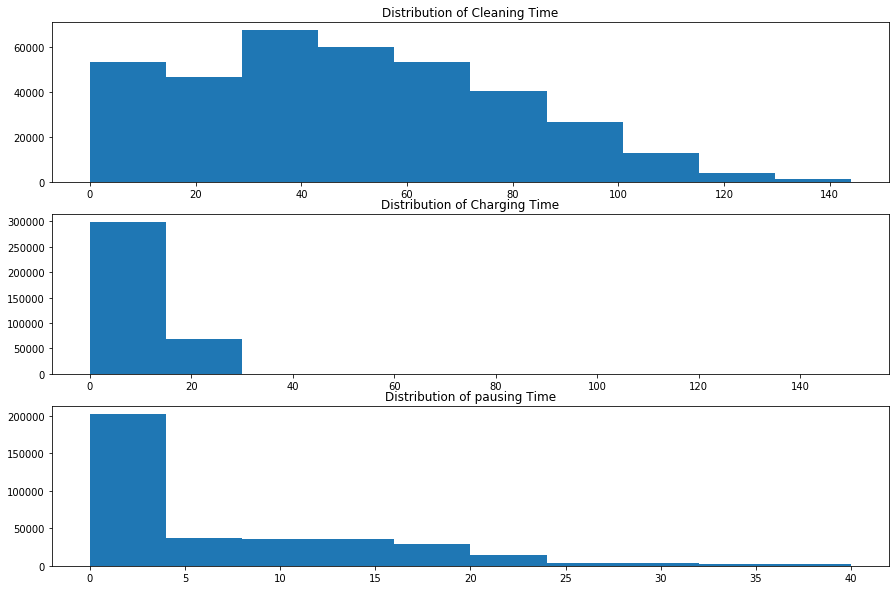

In [10]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(3,1,1)
ax1.hist(mission["runm"])
ax1.set_title("Distribution of Cleaning Time")
ax2 = fig.add_subplot(3,1,2)
ax2.hist(mission["chrgm"], range = (0,150))
ax2.set_title("Distribution of Charging Time")
ax3 = fig.add_subplot(3,1,3)
ax3.hist(mission["pausem"])
ax3.set_title("Distribution of pausing Time")


We can see that cleaning time has a relatively even distribution, ranging from 0min- 140min, averages around 40-60min. Most missions have charging time less than 10 mins, and pausing time less than 5 mins, although some missions do pause for more than 20min, which is quite long. 

# Feature Engineering

### Local date and time

Next, I would need to extract some features from the datetime column for further analysis. Since it follows UTC time, we need to first convert them into local time.

In [11]:
mission["datetime_object"] = mission["datetime"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [12]:
def convert(row):
    return pytz.utc.localize(row["datetime_object"]).astimezone(row["timezone"])

In [13]:
mission["local_time"] = mission.apply(convert, axis = 1)

In [14]:
mission["year"] = mission["local_time"].apply(lambda x: x.year)
mission["month"] = mission["local_time"].apply(lambda x: x.month)
mission["day"] = mission["local_time"].apply(lambda x: x.day)
mission["hour"] = mission["local_time"].apply(lambda x: x.hour)

Now that we have the proper local times, I will categorize the hour into morning, afternoon, and night and month into seasons

In [15]:
def hrlabel(hour):
    if 8<=hour<=12:
        return "morning"
    elif 12 < hour <= 18:
        return "afternoon"
    elif 18< hour <= 24:
        return "night"
    else:
        return "dawn"

In [16]:
mission["time_of_day"] = mission["hour"].apply(hrlabel)


### Usage Ratio

Another thing that could be interesting would be the "usage ratio": how much of the total time spent per mission is actual cleaning:

In [17]:
mission["usage_ratio"] = mission["runm"]/(mission["runm"] + mission["chrgm"] + mission["pausem"])

### Region

Finally, we can use the timezone column to categorize data into regions

In [18]:
def getregion(timezone):
    return timezone.split("/")[0]

In [19]:
mission["region"] = mission["timezone"].apply(getregion)

Given that Israel has so much data, it should have its own region. Also, places in South America should also be seperated out from North America.

In [20]:
mission.loc[mission["country_cd"] == "IL", "region"] = "Israel"
mission.loc[mission["timezone"].str.contains("Montevideo"), "region"] = "Latin_America"
mission.loc[mission["timezone"].str.contains("Argentina"), "region"] = "Latin_America"
mission.loc[mission["timezone"].str.contains("Guatemala"), "region"] = "Latin_America"
mission.loc[mission["timezone"].str.contains("Bahia"), "region"] = "Latin_America"
mission.loc[mission["timezone"].str.contains("Panama"), "region"] = "Latin_America"
mission.loc[mission["timezone"].str.contains("Bogota"), "region"] = "Latin_America"
mission.loc[mission["timezone"].str.contains("Jamaica"), "region"] = "Latin_America"
mission.loc[mission["timezone"].str.contains("Campo_Grande"), "region"] = "Latin_America"
mission.loc[mission["timezone"].str.contains("Nassau"), "region"] = "Latin_America"
mission.loc[mission["timezone"].str.contains("Paramaribo"), "region"] = "Latin_America"

In [21]:
mission["region"].value_counts()

Israel           220119
Europe            77708
Asia              43779
America           20311
Australia          3100
Latin_America      1319
Pacific             726
Atlantic            478
Africa              139
Name: region, dtype: int64

# Task 1 Region Analysis

### Usage_Ratio

In [22]:
usage_df = mission.groupby("region")["usage_ratio"].mean().sort_values(ascending = False)

Text(0.5, 1.0, 'Usage Ratio (running time/total time per mission) across different regions')

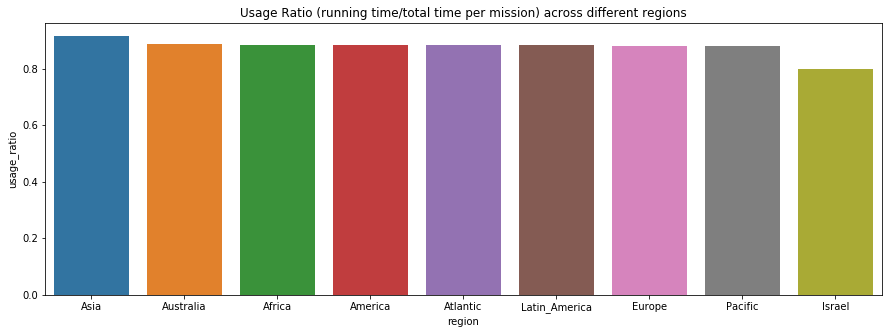

In [23]:
plt.figure(figsize = (15,5))
ax = sns.barplot(x = usage_df.index, y = usage_df)
ax.set_title("Usage Ratio (running time/total time per mission) across different regions")

### Average Pause Time

In [24]:
pause_df = mission.groupby("region")["pausem"].mean().sort_values()

Text(0.5, 1.0, 'Average Pause Time across different regions')

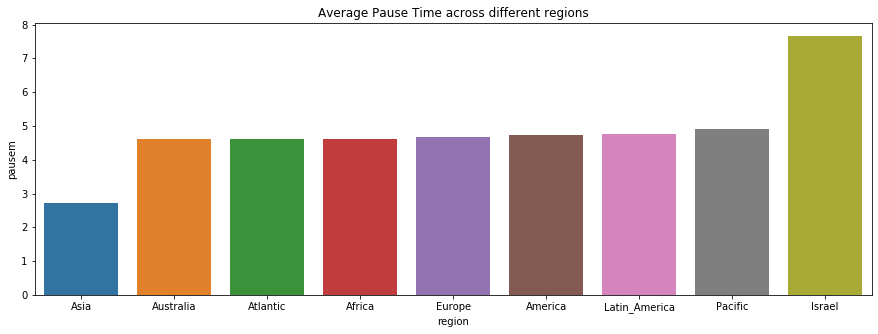

In [25]:
plt.figure(figsize = (15,5))
ax = sns.barplot(x = pause_df.index, y = pause_df)
ax.set_title("Average Pause Time across different regions")

Asia has the highest usage ratio and the lowest average pausetime, while Israel is entirely the opposite. The other regions are very similar to each other. The takeaway here is that robots run smoothly in Asia and engineers need to focus less on path engineering for products sold there. But they should pay special attention to products sold in Israel to reduce pause time and improve usage ratio.

### Charging

In [26]:
mission["charged"] = 0
mission.loc[mission["chrgm"] >0, "charged"] = 1

In [27]:
charge_df = mission.groupby("region")["charged"].sum()
charge_df_count = mission.groupby("region")["charged"].count()
charge_prop = (charge_df / charge_df_count).sort_values()

Text(0.5, 1.0, 'Proportion of times robot had to charge during mission')

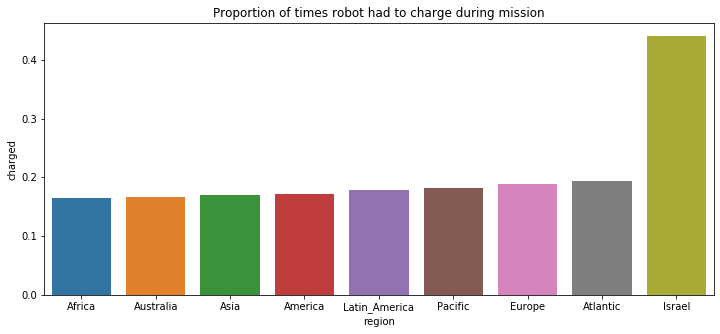

In [28]:
plt.figure(figsize = (12,5))
ax = sns.barplot(x = charge_prop.index, y = charge_prop)
ax.set_title("Proportion of times robot had to charge during mission")

This plot shows the percentage of times robot had to charge during a mission. Again, it seems like Israel is the odd one out. Products sold there should be installed with batteries that last longer.

### Cancelled mission analysis

Cancelled mission represents to a great extent when the mission is too long for the user. We can first see which countries have a huge proportion of cancelled missions and see what the runtimes are during cancelled mission.

In [29]:
cancelled_df = mission.groupby("country_cd")

# filter out country that has less than 100 datapoints
filtered_df = cancelled_df.filter(lambda x: x["runm"].count() > 100)

# get proportion of cancelled mission for each country
filtered_df["cancel"] = 0
filtered_df.loc[filtered_df["outcome"] == "cncl", "cancel"] = 1
cancel_prop_df = filtered_df.groupby("country_cd")["cancel"].sum()/filtered_df.groupby("country_cd")["cancel"].count() 

# get avg. runtime
temp = filtered_df[filtered_df["outcome"] == "cncl"]
cancel_runtime_df = temp.groupby("country_cd")["runm"].mean()
cancel_df = pd.concat([cancel_prop_df, cancel_runtime_df], axis = 1)


#top 10
cancel_df = cancel_df.sort_values(by = "cancel", ascending = False).iloc[:10,].reset_index()

In [30]:
geolocator = Nominatim(user_agent = "yifan")
def get_lat(country):
    try:
        latitude = geolocator.geocode(country).latitude
        return latitude
    except:
        return np.nan
def get_long(country):
    try:
        longitude = geolocator.geocode(country).longitude
        return longitude
    except:
        return np.nan
    
    

In [31]:
cancel_df["lat"] = cancel_df["country_cd"].apply(get_lat)
cancel_df["long"] = cancel_df["country_cd"].apply(get_long)

# fill in for IL 
cancel_df.iloc[0, 3] = 31.0461
cancel_df.iloc[0,4] = 34.8516


In [32]:

world_map= folium.Map()
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(cancel_df)):
        lat = cancel_df.iloc[i]['lat']
        long = cancel_df.iloc[i]['long']
        radius= cancel_df.iloc[i]["cancel"] * 50
        tooltip = "{country}: Percent of cancelled missions  {num}%".format(country = cancel_df.iloc[i]["country_cd"], num = round(cancel_df.iloc[i]["cancel"]*100))
        folium.CircleMarker(location = [lat, long], radius=radius, tooltip= tooltip, fill =True).add_to(marker_cluster)
#show the map
world_map
    


In the countries above, the cancelled mission takes up to more than 30% of the total missions, which means products sold in these countries should be designed with a shorter mission time. It seems like the optimal run time is between 40-50 minutes.

In [33]:
cancel_df

,country_cd,cancel,runm,lat,long
0,IL,0.475706,52.950139,31.046100,34.851600
1,ID,0.377049,40.021739,-2.483383,117.890285
2,IE,0.373832,37.775000,52.865196,-7.979460
3,KR,0.350746,48.319149,36.638392,127.696119
4,HU,0.340996,48.831461,47.181759,19.506094
5,AR,0.325048,54.252941,-34.996496,-64.967282
6,CL,0.309524,43.942308,-31.761336,-71.318770
7,CO,0.308696,45.028169,2.889443,-73.783892
8,PT,0.307353,46.818182,40.033263,-7.889626
9,HK,0.306836,47.217617,22.350627,114.184916


### Time of day

In [34]:
# create data
dummies = pd.get_dummies(mission["time_of_day"])
time_df = pd.concat([mission, dummies], axis = 1)

a = time_df.groupby("region")["morning"].sum()/time_df.groupby("region")["morning"].count()
b = time_df.groupby("region")["afternoon"].sum()/time_df.groupby("region")["afternoon"].count()
c= time_df.groupby("region")["night"].sum()/time_df.groupby("region")["night"].count()
d = time_df.groupby("region")["dawn"].sum()/time_df.groupby("region")["dawn"].count()

time_plot_df = pd.concat([a,b,c,d], axis = 1).reset_index()



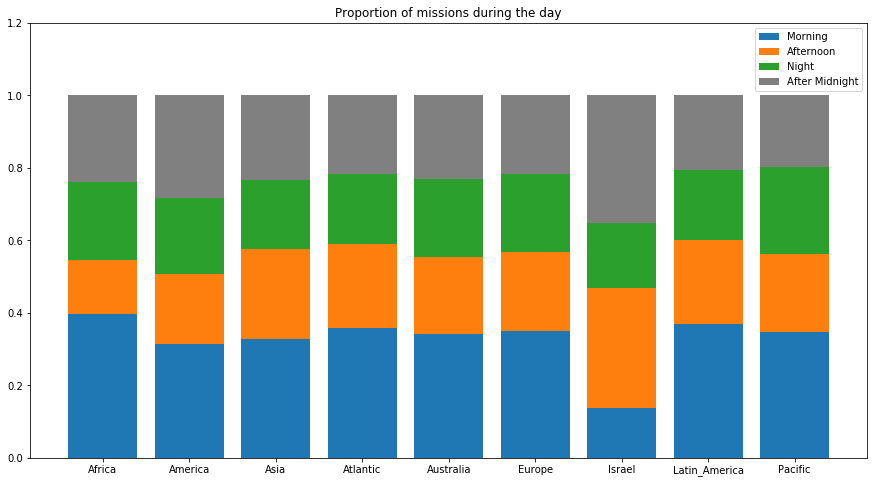

In [35]:
# plotting
plt.figure(figsize = (15,8))
p1 = plt.bar(time_plot_df["region"], time_plot_df["morning"])
p2 = plt.bar(time_plot_df["region"], time_plot_df["afternoon"], bottom = time_plot_df["morning"])
p3 = plt.bar(time_plot_df["region"], time_plot_df["night"], bottom = time_plot_df["morning"] + time_plot_df["afternoon"])
p4 = plt.bar(time_plot_df["region"], time_plot_df["dawn"], bottom = time_plot_df["morning"] + time_plot_df["afternoon"] +time_plot_df["night"], color = "grey")
plt.title("Proportion of missions during the day")
plt.ylim(0,1.2)
plt.legend((p1, p2, p3, p4), ("Morning", "Afternoon", "Night", "After Midnight"))

From the graph, we can see that most regions clean the most in the morning, except for Israel. African countries don't run missions as much in the afternoon, and Israel cleans 35% of the time between midnight and 8am. 

In [36]:
israel_time = mission[mission["country_cd"] == "IL"].groupby("hour").size().to_frame("freq")
israel_time = israel_time/len(mission[mission["country_cd"] == "IL"])
others_time = mission[mission["country_cd"] != "IL"].groupby("hour").size().to_frame("freq")
others_time = others_time/len(mission[mission["country_cd"] != "IL"])

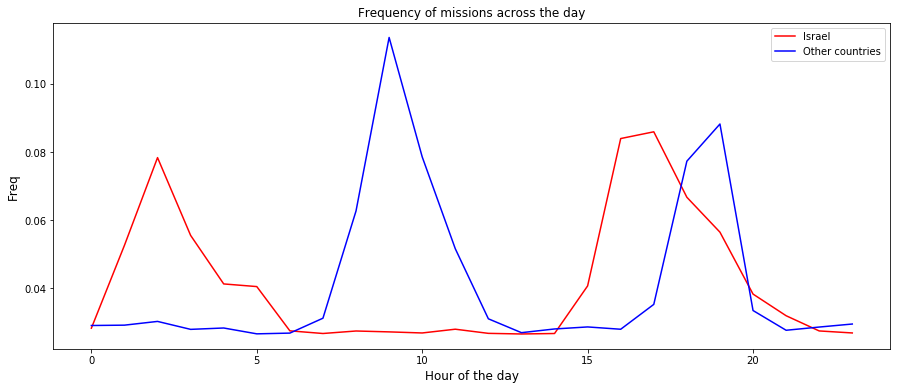

In [37]:
#lineplot 
fig, ax = plt.subplots(figsize = (15, 6))

ax.plot(israel_time.index , israel_time["freq"], color = "red", label = "Israel")
ax.plot(others_time.index , others_time["freq"], color = "blue", label = "Other countries")
plt.title("Frequency of missions across the day")
plt.xlabel("Hour of the day",size =12)
plt.ylabel("Freq", size = 12)
ax.legend()





For most countries, there is a peak in usage around 9-10am and 7pm-8pm. However, for Israel, the peak is around 2-3am and 4pm-5pm.


# Task 2 Inter-Mission Interval

In calculating the IMI, obviously we won't have data for all the rows. We would only have data if the two consecutive rows are the same robot and the mission number is consecutive.

In [38]:
def extract_IMI(row, previous_row):
    if row["robotid"] != previous_row["robotid"]:
        return 0
    elif row["nmssn"] != previous_row["nmssn"]+1:
        return 0
    else:
        return row["datetime_object"] - previous_row["datetime_object"]

In [39]:
IMI = []
for i in range(1, len(mission)):
        IMI.append(extract_IMI(mission.iloc[i], mission.iloc[i-1]))

In [40]:
# convert to hours
IMI_hours = []
for entry in IMI: 
    if entry == 0:
        IMI_hours.append(entry)
    else:
        IMI_hours.append(entry.days*24 + entry.seconds//3600)

In [41]:
IMI.append(0)
IMI_hours = pd.DataFrame(IMI_hours)

In [42]:
mission_IMI = pd.concat([mission, IMI_hours], axis =1)

In [43]:
mission_IMI.rename(columns = {0: "IMI_hours"}, inplace = True)

### Mission Outcome and IMI

The IMI_hours column represents the hours before the next clean-up happens for each row. We could have reasons to expect that IMI might be shorter when the session went smoothly, but also we could also suspect that when the robot is stuck, IMI might be shorter because it failed to clean the whole room. This is analysis we can perform. First, we need to remove all the rows that have IMI_hours = 0 as those are not consecutive rows. Also, some rows have IMI_hours <0 which are data errors.

In [44]:
mission_IMI_f = mission_IMI[mission_IMI["IMI_hours"] > 0]

[Text(0.5, 1.0, 'IMI vs. outcome Box Plot')]

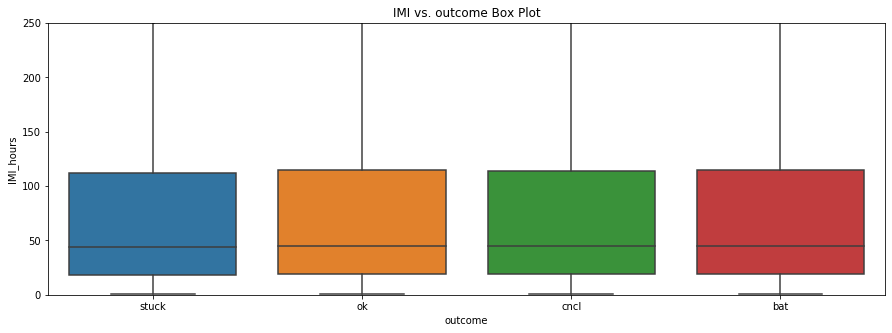

In [45]:
plt.figure(figsize = (15,5))
ax = sns.boxplot(x = mission_IMI_f["outcome"], y = mission_IMI_f["IMI_hours"])
ax.set(ylim = (0,250))
ax.set(title = "IMI vs. outcome Box Plot")


To my surprise, there is practically no difference between the categories. This is an important insight nevertheless, showing that user experience actually has little impact on IMI.

### IMI in different month

[Text(0.5, 1.0, 'IMI vs. Month boxplot')]

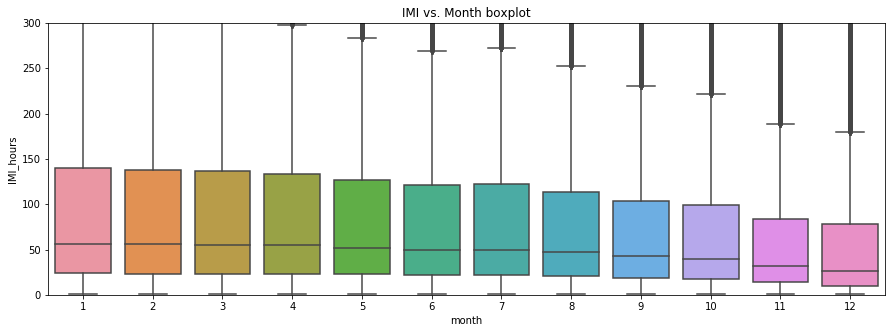

In [46]:
plt.figure(figsize = (15,5))
ax = sns.boxplot(x = mission_IMI_f["month"], y = mission_IMI_f["IMI_hours"])
ax.set(ylim = (0,300))
ax.set(title = "IMI vs. Month boxplot")

It seems like people clean more frequently in November and December, maybe it's holiday season. We could potentially group them together to conduct a t-test, to see if the IMI is significantly different than the rest of the year. 

##### t-test

In [47]:
holiday_test = mission_IMI_f

In [48]:
holiday = holiday_test[(holiday_test["month"] == 11) | (holiday_test["month"] ==12)]
holiday_mean = holiday["IMI_hours"].mean()
holiday_std = (stat.stdev(holiday["IMI_hours"]))**2

non_holi = holiday_test[(holiday_test["month"] != 11) | (holiday_test["month"] !=12)]
non_holi_mean = non_holi["IMI_hours"].mean()
non_holi_std = (stat.stdev(holiday["IMI_hours"]))**2

In [49]:
pooled = (holiday_std/len(holiday) + non_holi_std/len(non_holi))** (1/2)
t_stat = (non_holi_mean - holiday_mean)/pooled
df = len(holiday) + len(non_holi) -2
p_value = 1 - stats.t.cdf(t_stat, df =df)
print("the p_value of the test is " + str(p_value))

the p_value of the test is 0.0


Our null hypothesis is that holiday season (Nov and Dec) have the same IMI as the rest of the year. We reject the null with strong evidence (p_value =0). People do seem to use the robot more often in Nov. and Dec.

### Low IMI countries

Low IMI countries represent good opportunity to further sell robots and supplementary materials.

In [67]:
# filter out countries with <100 datapoints
temp = mission_IMI_f.groupby("country_cd").filter(lambda x: x["runm"].count() > 100)

#take the top 10 countries with the lowest IMI
IMI_top_df = temp.groupby("country_cd")["IMI_hours"].mean().sort_values().iloc[:10,]
IMI_top = IMI_top_df.reset_index()

# assign geo location
IMI_top["long"] = IMI_top["country_cd"].apply(get_long)
IMI_top["lat"] = IMI_top["country_cd"].apply(get_lat)

In [74]:
# plot
world_map= folium.Map()
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(IMI_top)):
        lat = IMI_top.iloc[i]['lat']
        long = IMI_top.iloc[i]['long']
        radius= (IMI_top.iloc[i]["IMI_hours"] * (-1)) + 100 
        tooltip = "{country}: IMI of {num} hours".format(country = IMI_top.iloc[i]["country_cd"], num = round(IMI_top.iloc[i]["IMI_hours"]))
        folium.CircleMarker(location = [lat, long], radius=radius, tooltip= tooltip, fill =True).add_to(marker_cluster)
#show the map
world_map

### IMI Regression

Regression is a great way to understand how different features relate to IMI. 

In [83]:
# create dummies for outcome, month, time_of_day, region
outcome_dummies = pd.get_dummies(mission_IMI_f['outcome'])
month_dummies = pd.get_dummies(mission_IMI_f["month"], prefix = "Month")
time_dummies = pd.get_dummies(mission_IMI_f['time_of_day'])
region_dummies = pd.get_dummies(mission_IMI_f['region'])


In [150]:
regress_df = pd.concat([mission_IMI_f, outcome_dummies, month_dummies, time_dummies, region_dummies], axis = 1)
regress_df = regress_df.dropna()

#retrive all regressors
temp = outcome_dummies.columns.append(month_dummies.columns).append(time_dummies.columns).append(region_dummies.columns)
cols = []
for i in ["runm", "chrgm", "pausem", "usage_ratio"]:
    cols.append(i)
for i in temp:
    cols.append(i)

# drop one for each cate as baseline
cols.remove("ok")
cols.remove("Month_1")
cols.remove("morning")
cols.remove("America")
 


#model
X = regress_df[cols]
Y = regress_df["IMI_hours"]
lm = sm.OLS(Y, X)
a = lm.fit()
print(a.summary())


                                 OLS Regression Results                                
Dep. Variable:              IMI_hours   R-squared (uncentered):                   0.196
Model:                            OLS   Adj. R-squared (uncentered):              0.196
Method:                 Least Squares   F-statistic:                              2060.
Date:                Tue, 04 Aug 2020   Prob (F-statistic):                        0.00
Time:                        23:50:04   Log-Likelihood:                     -1.6742e+06
No. Observations:              245059   AIC:                                  3.349e+06
Df Residuals:                  245030   BIC:                                  3.349e+06
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

We only care about the covariates that are statistically significant (p_value < 0.01). I will present the insights in the conclusion.

# Conclusion

Here are the main insights from the project:

1) Asia (excluding Israel)'s Usage ratio is the highest and its average pause time is by far the lowest. This means products there are running smoothly and product design team can perhams spend less time on the path engineering on products sold there.

2) Israel is very interesting. Its pause time is much higher than other regions. Almost 50% of the time, the robot has to charge during the mission, which is much higher than other regions. This suggests that they need better path engineering and longer battery life.

3) I identified 10 countries where users decided to cancel more than 30% of the time, including Israel, Hong Kong, Korea, Ireland, Columbia etc. The company could consider shorten the mission for these areas. The optimal mission time seems to be around 40 - 50 mins.

4) While people in most regions clean most often in the morning, around 10am, Israel has a huge peak around 2am-3am. This might explain why they have such a high cancel percentage and a high "need to charge" percentage. No one wants to run 90 min sessions at 2am and also this could disturb robot's regular charging at night. The company should consider designing a specific product for the region that takes this into account.

5) From the IMI analysis, people seem to clean very often during the holiday season (Nomvember + December). A t-test rejects the null that the holiday season is not different from the rest of the year.

6) I identified 10 countries that have the lowest IMI, including Ireland (26 hours), Latvia (73 hours), Sweden, Singapore etc. These markets would be further exploited to sell more robots or complementary things such as replacement trays or batteries.

7) From the regression analysis, we see the usage_ratio actually affects IMI. When the robot works better, the IMI is longer. Comparing to Jan., later months in the year (after July) has lower IMI. People who clean in the morning has a slightly lower IMI. Comparing to America, Europe, Israel and Latin America have longer IMI. Other regions are statistically insignificant.